# Overview

This notebook visualizes cells from the following three datasets in a joint embedding space generated using Structural clusters.  
These data are used to generate interactive HTML plots using [Plotly](https://plotly.com/python/).

- sample ["Brain8"](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM3768152) from the [Jiang et al. 2021](https://www.frontiersin.org/articles/10.3389/fcell.2021.743421/full) zebrafish cell atlas
- sample ["Brain1"](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM2906405) from the [Han et al. 2018](https://www.sciencedirect.com/science/article/pii/S0092867418301168#sec4) mouse cell atlas
- sample ["Xenopus_brain_COL65"](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM6214268) from the [Liao et al. 2022](https://www.nature.com/articles/s41467-022-31949-2) Xenopus laevis adult cell atlas


# 0. Setup

Import packages and specify any important functions here.

In [5]:
# import standard python packages
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import arcadia_pycolor as apc
import matplotlib as mpl

# 1. Load cell positions and labels in UMAP

In [6]:
df = pd.read_csv('DrerMmusXlae_adultbrain_FoldSeek_plotlydata.tsv', sep = '\t')
df['leiden_str'] = df['leiden'].astype('str')
df.sort_values('leiden', inplace = True)
display(df)

barcode species  n_genes_by_counts  total_counts  \
3982  Drer_GCTGTGTTTAGGTACTTC    Drer                251         661.0   
5236  Drer_CTCGCATACTTCTAGTCG    Drer                215         507.0   
5235  Drer_CGAGTACTCCATCTCCAT    Drer                218         529.0   
5234  Drer_CGAGTACGTGGCGCAGGA    Drer                242         547.0   
8791  Drer_CCTAGATCACTTGCTCAA    Drer                174         379.0   
...                       ...     ...                ...           ...   
3327  Drer_GATCTTATTCCAGGGTTT    Drer                208         495.0   
8259  Drer_ACTTATTGTGCGACACCC    Drer                182         430.0   
236   Drer_AACCTAGCAGGATGCAAT    Drer                299        1104.0   
1526  Drer_ACGTTGCTTCTGCAACAA    Drer                234         790.0   
1757  Drer_GGACATGAACGCTTTAGG    Drer                228         626.0   

      n_genes                        celltype  leiden    umap_1     umap_2  \
3982      251            Drer_Oligodendrocyte       0 -0.710372  14.685410   
5236      215            Drer_Oligodendrocyte       0  0.072930  14.979373   
5235      218            Drer_Oligodendrocyte       0 -1.604716  15.935637   
5234      242       Drer_Microglia_apoc1_high       0 -1.512169  14.129916   
8791      174            Drer_Oligodendrocyte       0 -0.011005  13.513034   
...       ...                             ...     ...       ...        ...   
3327      208  Drer_Epithelial_cell_krt5_high      20 -0.909708   9.801559   
8259      182  Drer_Epithelial_cell_krt5_high      20 -0.996329   9.807927   
236       299  Drer_Epithelial_cell_krt5_high      20 -1.190824   9.752467   
1526      234  Drer_Epithelial_cell_krt5_high      20 -0.860482   9.920297   
1757      228  Drer_Epithelial_cell_krt5_high      20 -0.940552   9.777720   

     leiden_str  
3982          0  
5236          0  
5235          0  
5234          0  
8791          0  
...         ...  
3327         20  
8259         20  
236          20  
1526         20  
1757         20  

[22117 rows x 10 columns]

# 2. Set up palette dictionaries

In [7]:
cluster_mapper = dict(zip(sorted(df['leiden'].unique()), list(apc.arcadia_All_ordered.values()) + [apc.arcadia_Neutral['arcadia:crow']]))
species_mapper = {'Drer': apc.arcadia_All_ordered['arcadia:aster'], 'Mmus': apc.arcadia_All_ordered['arcadia:rose'], 'Xlae': apc.arcadia_All_ordered['arcadia:seaweed']}
drer_celltype_palette = {
    # unlabeled, lightgrey
    'Unlabeled': apc.arcadia_Core['arcadia:lightgrey'],
    
    # myeloid cells, dragon-orange-rose-amber
    'Erythrocyte': mpl.colors.to_hex(apc.adjust_lightness(apc.arcadia_Accent_all['arcadia:dragon'], 0.8)),
    'Innate_immune_cell': apc.arcadia_Accent_all['arcadia:orange'],
    'Granulocyte': apc.arcadia_Accent_all['arcadia:rose'],
    'Macrophage': apc.arcadia_Accent_all['arcadia:amber'],
    'Macrophage_grn1_high': mpl.colors.to_hex(apc.adjust_lightness(apc.arcadia_Accent_all['arcadia:dress'], 1)),
    
    # lymphoid cells, 
    'T_cell': mpl.colors.to_hex(apc.adjust_lightness(apc.arcadia_Accent_all['arcadia:marineblue'], 1)),
    
    # radial glia: lime-sage
    'Regenerating_Radial_gliacell': apc.arcadia_Accent_all['arcadia:sage'],
    'Radial_glia': apc.arcadia_Accent_all['arcadia:lime'],
    'Radial_glia_mdkb_high': mpl.colors.to_hex(apc.adjust_lightness(apc.arcadia_Accent_all['arcadia:lime'], 0.6)),
    'Quiescent_Radial_gliacell': mpl.colors.to_hex(apc.adjust_lightness(apc.arcadia_Accent_all['arcadia:lime'], 0.3)),
    
    # microglia, aster-periwinkle
    'Microglia': apc.arcadia_Accent_all['arcadia:periwinkle'],
    'Microglia_apoc1_high': apc.arcadia_Accent_all['arcadia:aster'],
    'Proliferating_cell': mpl.colors.to_hex(apc.adjust_lightness(apc.arcadia_Accent_all['arcadia:periwinkle'], 0.7)),
    
    # epithelial cells, aegean-wish-vitalblue
    'Epithelial_cell': mpl.colors.to_hex(apc.adjust_lightness(apc.arcadia_Accent_all['arcadia:aegean'], 0.8)),
    'Epithelial_cell_krt5_high': apc.arcadia_Accent_all['arcadia:vitalblue'],
    'Meningeal_mural_lymphatic_endothelial_cell': apc.arcadia_Accent_all['arcadia:bluesky'],
    
    # oligodendrocytes: chateau-taupe
    'Oligodendrocyte': mpl.colors.to_hex(apc.adjust_lightness(apc.arcadia_Accent_all['arcadia:chateau'], 0.7)),
    'Oligodendrocyte_sla_high': apc.arcadia_Accent_all['arcadia:taupe'],
    
    # neuron: seaweed-mint-forest
    'Neuron': apc.arcadia_Accent_all['arcadia:seaweed'],
    'Neuron_kiss_high': mpl.colors.to_hex(apc.adjust_lightness(apc.arcadia_Accent_all['arcadia:seaweed'], 0.6)),
    'Neuroblast': mpl.colors.to_hex(apc.adjust_lightness(apc.arcadia_Core['arcadia:forest'], 0.8)),
    'Neural_stem_cell': apc.arcadia_Accent_all['arcadia:mint'],
    'Neural_progenitor_cell': mpl.colors.to_hex(apc.adjust_lightness(apc.arcadia_Accent_all['arcadia:sage'], 0.6))
}
mmus_celltype_palette = {
    # unlabeled, lightgrey
    'Unlabeled': apc.arcadia_Core['arcadia:lightgrey'],
    
    'Macrophage_Lyz2 high': apc.arcadia_Accent_all['arcadia:amber'],
    'Macrophage_Klf2 high': mpl.colors.to_hex(apc.adjust_lightness(apc.arcadia_Accent_all['arcadia:dress'], 1)),

    'Myelinating oligodendrocyte': mpl.colors.to_hex(apc.adjust_lightness(apc.arcadia_Accent_all['arcadia:chateau'], 0.7)),
    'Oligodendrocyte precursor cell': apc.arcadia_Accent_all['arcadia:taupe'],
    'Schwann cell': mpl.colors.to_hex(apc.adjust_lightness(apc.arcadia_Accent_all['arcadia:chateau'], 0.5)),
    
    'Neuron': apc.arcadia_Accent_all['arcadia:seaweed'],
    'Pan-GABAergic': mpl.colors.to_hex(apc.adjust_lightness(apc.arcadia_Core['arcadia:forest'], 1)),
    
    'Astrocyte_Atp1b2 high': mpl.colors.to_hex(apc.adjust_lightness(apc.arcadia_Accent_all['arcadia:lime'], 1)),
    'Astrocyte_Mfe8 high': mpl.colors.to_hex(apc.adjust_lightness(apc.arcadia_Accent_all['arcadia:lime'], 0.3)),
    'Astroglial cell(Bergman glia)': mpl.colors.to_hex(apc.adjust_lightness(apc.arcadia_Accent_all['arcadia:lime'], 0.6)),
    'Hypothalamic ependymal cell': apc.arcadia_Accent_all['arcadia:sage'],
    
    'Microglia': apc.arcadia_Accent_all['arcadia:periwinkle'],
}
xlae_celltype_palette = {
    # unlabeled, lightgrey
    'Unlabeled': apc.arcadia_Core['arcadia:lightgrey'],
    
    # myeloid cells, dragon-orange-rose-amber
    'Erythrocyte': mpl.colors.to_hex(apc.adjust_lightness(apc.arcadia_Accent_all['arcadia:dragon'], 0.8)),
    'Proliferating myeloid cell': mpl.colors.to_hex(apc.adjust_lightness(apc.arcadia_Accent_all['arcadia:mars'], 1)),
    'Eosinophil': apc.arcadia_Accent_all['arcadia:rose'],
    'Macrophage': apc.arcadia_Accent_all['arcadia:amber'],
    'Mast cell': mpl.colors.to_hex(apc.adjust_lightness(apc.arcadia_Accent_all['arcadia:rose'], 0.3)),
    
    # lymphoid cells
    'Antigen-presenting cell': mpl.colors.to_hex(apc.adjust_lightness(apc.arcadia_Accent_all['arcadia:marineblue'], 0.7)),
    'T progenitor cell': mpl.colors.to_hex(apc.adjust_lightness(apc.arcadia_Accent_all['arcadia:denim'], 1)),
    'CD8+ T cell': mpl.colors.to_hex(apc.adjust_lightness(apc.arcadia_Accent_all['arcadia:marineblue'], 1)),
    'Plasma B cell': mpl.colors.to_hex(apc.adjust_lightness(apc.arcadia_Accent_all['arcadia:denim'], 0.5)),
    
    # endocrine cells
    'Growth hormone progenitor cell': mpl.colors.to_hex(apc.adjust_lightness(apc.arcadia_Accent_all['arcadia:wish'], 1)),
    'Growth hormone cell_hnrnpk high': mpl.colors.to_hex(apc.adjust_lightness(apc.arcadia_Accent_all['arcadia:wish'], 0.8)),
    'Growth hormone cell_rasd1 high': mpl.colors.to_hex(apc.adjust_lightness(apc.arcadia_Accent_all['arcadia:wish'], 0.6)),
    'Growth hormone cell_Rp high': mpl.colors.to_hex(apc.adjust_lightness(apc.arcadia_Accent_all['arcadia:wish'], 0.4)),
    'Thyrotroph cell': apc.arcadia_Neutral['arcadia:bark'],
    'Gonadotroph cell_cga high': mpl.colors.to_hex(apc.adjust_lightness(apc.arcadia_Accent_all['arcadia:blossom'], 1)),
    'Gonadotroph cell_cyp21a2.1 high': mpl.colors.to_hex(apc.adjust_lightness(apc.arcadia_Accent_all['arcadia:blossom'], 0.8)),
    'Endocrine progenitor cell_st6galnac2 high': mpl.colors.to_hex(apc.adjust_lightness(apc.arcadia_Accent_all['arcadia:orange'], 0.7)),
    'Endocrine progenitor cell_chgb high': mpl.colors.to_hex(apc.adjust_lightness(apc.arcadia_Accent_all['arcadia:orange'], 0.5)),
    'Melanotrope cell': apc.arcadia_Neutral['arcadia:crow'],
    'Prolactin progenitor cell': mpl.colors.to_hex(apc.adjust_lightness(apc.arcadia_Accent_all['arcadia:canary'], 0.6)),
    
    # neuron: seaweed-mint-forest
    'Excitatory neuron_tac1 high': apc.arcadia_Accent_all['arcadia:seaweed'],
    'Excitatory neuron_zbtb18 high': apc.arcadia_Accent_all['arcadia:mint'],
    'Excitatory neuron_mex3a high': mpl.colors.to_hex(apc.adjust_lightness(apc.arcadia_Accent_all['arcadia:seaweed'], 0.6)),
    'GABAergic neuron_tac1 high': mpl.colors.to_hex(apc.adjust_lightness(apc.arcadia_Core['arcadia:forest'], 1)),
    'GABAergic neuron_scgn high': mpl.colors.to_hex(apc.adjust_lightness(apc.arcadia_Core['arcadia:forest'], 1.1)),
    'GABAergic neuron_sst high': mpl.colors.to_hex(apc.adjust_lightness(apc.arcadia_Core['arcadia:forest'], 1.2)),
    
    # oligodendrocytes: chateau-taupe
    'Myelinating oligodendrocyte progenitor cell': mpl.colors.to_hex(apc.adjust_lightness(apc.arcadia_Accent_all['arcadia:chateau'], 0.7)),
    'Oligodendrocyte precursor cell': apc.arcadia_Accent_all['arcadia:taupe'],
    
    # astrocytes
    'Fibrous astrocyte': apc.arcadia_Accent_all['arcadia:sage'],
    'Astrocyte_slc1a3 high': mpl.colors.to_hex(apc.adjust_lightness(apc.arcadia_Accent_all['arcadia:lime'], 0.6)),
    'Astrocyte_adcyap1r1 high': mpl.colors.to_hex(apc.adjust_lightness(apc.arcadia_Accent_all['arcadia:lime'], 0.3)),
    'Radial glia': apc.arcadia_Accent_all['arcadia:lime'],
    
    # endothelial cell
    'Capillary endothelial cell': mpl.colors.to_hex(apc.adjust_lightness(apc.arcadia_Accent_all['arcadia:bluesky'], 0.7)),
    'Endothelial cell': apc.arcadia_Accent_all['arcadia:bluesky'],
    
    # other
    'Rp_high': apc.arcadia_Accent_all['arcadia:oat'],
    'Rod photoreceptor':  apc.arcadia_Accent_all['arcadia:canary'],
    
    # microglia
    'Microglia': apc.arcadia_Accent_all['arcadia:periwinkle'],
    'Proliferating cell': mpl.colors.to_hex(apc.adjust_lightness(apc.arcadia_Accent_all['arcadia:periwinkle'], 0.7)),
}

drer_celltype_palette_pre = {'Drer_' + key: value for key, value in drer_celltype_palette.items()}
mmus_celltype_palette_pre = {'Mmus_' + key: value for key, value in mmus_celltype_palette.items()}
xlae_celltype_palette_pre = {'Xlae_' + key: value for key, value in xlae_celltype_palette.items()}

celltype_mapper = drer_celltype_palette_pre | mmus_celltype_palette_pre | xlae_celltype_palette_pre | {'Unlabeled': apc.arcadia_Core['arcadia:lightgrey']}

# 3. Generate switchable plot figure using plotly

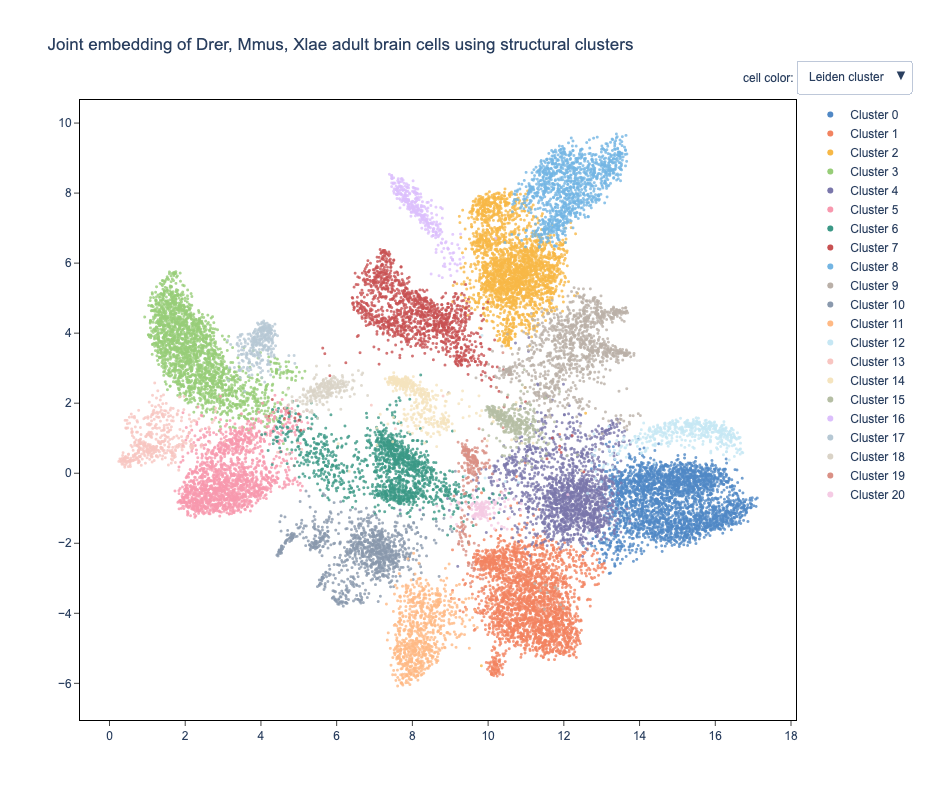

In [8]:
fig = go.Figure()

scatter_data = [go.Scatter(
    x = df['umap_2'],
    y = df['umap_1'],
    mode='markers',
    marker=dict(
        color = df['leiden'].map(cluster_mapper),
        size = 3,
        opacity = 0.8
    ),
    text = df['barcode'],
    customdata = df[['celltype', 'leiden']],
    showlegend = False
)]

cluster_legend_data = [go.Scatter(x = [None], y = [None], mode = 'markers', name = ('Cluster ' + str(key)).ljust(19), marker = dict(color = value), visible = True) for key, value in cluster_mapper.items()]
species_legend_data = [go.Scatter(x = [None], y = [None], mode = 'markers', name = str(key).ljust(20), marker = dict(color = value), visible = False) for key, value in species_mapper.items()]
celltype_legend_data = [go.Scatter(x = [None], y = [None], mode = 'markers', name = 'Unlabeled' if key == 'Unlabeled' else key[0] + ':' + key[5:15] + '...' if len(key[5:]) > 10 else key[0] + ':' + key[5:], marker = dict(color = value), visible = False) for key, value in celltype_mapper.items()]

legend_data = cluster_legend_data + species_legend_data + celltype_legend_data
legend_colors = [i for i in (cluster_mapper | species_mapper | celltype_mapper).values()]

fig = go.Figure(data = scatter_data + legend_data)

fig.update_traces(mode="markers")

fig.update_traces(
    hovertemplate="<br>".join([
        "<b>Cell Barcode:</b> %{text}", 
        "<b>Leiden cluster %{customdata[1]}</b>", 
        "<b>celltype:</b> %{customdata[0]}",
        "<extra></extra>"
    ])
)

button_layer_1_height = 1.08
fig.update_layout(
    updatemenus=[
        dict(
            buttons=list([
                dict(
                    args=[{'marker': [{'color': df['leiden'].map(cluster_mapper), 'size': 3, 'opacity': 0.75}] + [{'color': i} for i in legend_colors],
                          'visible': [True] + [True] * len(cluster_legend_data) + [False] * len(species_legend_data) + [False] * len(celltype_legend_data)}],
                    label="Leiden cluster",
                    method="update"
                ),
                dict(
                    args=[{'marker': [{'color': df['species'].map(species_mapper), 'size': 3, 'opacity': 0.75}] + [{'color': i} for i in legend_colors],
                          'visible': [True] + [False] * len(cluster_legend_data) + [True] * len(species_legend_data) + [False] * len(celltype_legend_data)}],
                    label="species",
                    method="update"
                ),
                dict(
                    args=[{'marker': [{'color': df['celltype'].map(celltype_mapper), 'size': 3, 'opacity': 0.75}] + [{'color': i} for i in legend_colors],
                          'visible': [True] + [False] * len(cluster_legend_data) + [False] * len(species_legend_data) + [True] * len(celltype_legend_data)}],
                    label="celltype",
                    method="update"
                )
            ]),
            direction="down",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=1,
            xanchor="left",
            y=button_layer_1_height,
            yanchor="top"
        )
    ]
)

fig.update_layout(
    autosize = False,
    width = 850,
    height = 800,
    legend = {'traceorder': 'normal'},
    plot_bgcolor='white',
    title = 'Joint embedding of Drer, Mmus, Xlae adult brain cells using structural clusters'
)

fig.update_xaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black'
)
fig.update_yaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black'
)

fig.update_layout(
    annotations=[
        dict(text="cell color:", x=1, xref="paper", y=1.05, yref="paper",
                             align="left", showarrow=False)
    ])

try: 
    fig.update_layout(font=dict(family="Arial"))
except:
    pass

fig.update_xaxes(showspikes=True)
fig.update_yaxes(showspikes=True)

fig.write_html('figures/' + 'DrerMmusXlae_SC_plotly_jitterlegend.html')

config = {
  'toImageButtonOptions': {
    'format': 'svg', # one of png, svg, jpeg, webp
    'filename': 'DrerMmusXlae_OrthoFinder_snapshot',
    'height': 850,
    'width': 800,
    'scale': 1 # Multiply title/legend/axis/canvas sizes by this factor
  }
}

fig.show(config = config)